# Data exploration

### Contents
1. imports
1. [load subset](#subsetLoad)

In [1]:
import laspy
from scipy.spatial import cKDTree
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from sklearn.preprocessing import MinMaxScaler


import geopandas as gpd
from shapely.geometry import Polygon, Point
import pandas as pd

pd.set_option("display.max_columns", 100)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

# preprocessing and scoring
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from sklearn.ensemble import RandomForestClassifier



In [2]:
def get_spatial_subset(
    full_cloud, xmin: int, xmax: int, ymin: int, ymax: int
) -> laspy.lasdata.LasData:
    """
    Create a subset of a LAS file based on a bounding box in coordinates of the cloud file

    parameters:
    full_cloud: a laspy cloud object you want to subset from

    xmin: the values of the bounding box object
    xmax
    ymin
    ymax

    returns: laspy.lasdata.LasData object
    """

    # create empty laspy collection to put the filtered points in that has the same format and file version as the original
    new_file = laspy.create(
        point_format=cloud.header.point_format, file_version=cloud.header.version,
    )

    # create matrices of boolean values
    a = cloud.x > xmin
    b = cloud.x < xmax
    c = cloud.y > ymin
    d = cloud.y < ymax
    # subset the points and put them into the new laspy file
    new_file.points = full_cloud.points[a & b & c & d]

    new_file.header.offsets = full_cloud.header.offsets
    new_file.header.scales = full_cloud.header.scales

    return new_file


In [3]:
# load in the fully LAZ file
cloud = laspy.read(r"./data/AHN4_Noordwijk.laz")


In [4]:
# define the area of interest
xcenter = 89401.42414516  # 89400
bbbox_size_length = 170  # 300
bbbox_size_width = 100  # 300
ycenter = 472877.83174913  # 472868
xmin = xcenter - 0.5 * bbbox_size_length
xmax = xcenter + 0.5 * bbbox_size_length
ymin = ycenter - 0.5 * bbbox_size_width
ymax = ycenter + 0.5 * bbbox_size_width

# create the subset
subset = get_spatial_subset(cloud, xmin, xmax, ymin, ymax)


# # saving the bounds as a shapefile

lat_point_list = [ymin, ymin, ymax, ymax, ymin] 
lon_point_list = [xmin, xmax ,xmax, xmin, xmin]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs_28992 = {'init':'epsg:28992'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs_28992, geometry=[polygon_geom])       
print(polygon.geometry)

# polygon.to_file(filename='./data/bounds_new.geojson', driver='GeoJSON') # geojson export has a problem with how it is saved, doesnt render in QGIS
polygon.to_file(filename='./data/bounds_new.shp', driver="ESRI Shapefile")


0    POLYGON ((89316.424 472827.832, 89486.424 4728...
Name: geometry, dtype: geometry


C:\Users\maxli\anaconda3\envs\laspy_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
# create a tree for all points in the subset
dataset = np.vstack((subset.X, subset.Y, subset.Z)).transpose()
tree = cKDTree(dataset)



In [6]:
# setting up the extra dimensions to add back to the las file
dimension_list = [
    laspy.point.format.ExtraBytesParams("normal_angle", "float64"),
    laspy.point.format.ExtraBytesParams("linearity15", "float64"),
    laspy.point.format.ExtraBytesParams("planarity15", "float64"),
    laspy.point.format.ExtraBytesParams("scat15", "float64"),
    laspy.point.format.ExtraBytesParams("curve15", "float64"),
]

for dim in dimension_list:
    subset.add_extra_dim(dim)

# check that it was added correctly
list(subset.point_format.extra_dimension_names)


['Deviation',
 'Reflectance',
 'Amplitude',
 'normal_angle',
 'linearity15',
 'planarity15',
 'scat15',
 'curve15']

In [7]:
# get an array for all the points
all_points = subset.points.array

In [8]:
def _fit_plane_pca(point, tree, k) -> PCA:
    """
    internal function designed to fit a PCA model to the k nearest points to a point
    parameters:
    point: single point as structured ndarray of point data returned from laspy.points.array()
    tree: the KD tree for the points
    k: number of neighbors to consider

    returns:
    fitted pca model: sklean.decom
    """
    distances, neighbors_indices = tree.query((point[0], point[1], point[2]), k)

    neighbors_points = tree.data[neighbors_indices]
    # set up pca model
    pca = PCA(n_components=3)
    # fit the model to the points
    pca.fit(neighbors_points)
    return pca


def _find_angle(vector, axis="z"):
    axis_lookup = {"z": [0, 0, 1], "y": [0, 1, 0], "x": [1, 0, 0]}
    unit_vector = axis_lookup[axis]
    # find the angle with the z axis using the dot product
    angle = np.rad2deg(np.arccos(vector.dot(unit_vector)))

    # we want all the normals pointing in the same direction

    if angle > 90:
        # if the vector is pointing the wrong way, flip it
        vector = vector * -1
        # find the angle of the new vector
        angle = np.rad2deg(np.arccos(vector.dot(unit_vector)))

    return angle

In [9]:
def pca_3d_shape(point_array: np.array, tree: cKDTree, k: int = 8) -> np.array:
    """
    takes an array of points from laspy, a kd tree, and an integer number of neighbors to sample


    returns an array of:

    linearity, planarity, scattering, omnivariance, anisotropy, eigenentropy, eigsum, ch_cur

    """
    length_parray = len(point_array)
    normal_angle = np.zeros(length_parray)
    normal_vectors = np.zeros((length_parray, 3))
    # set up empty arrays
    linearity = np.zeros(length_parray)
    planarity = np.zeros(length_parray)
    scattering = np.zeros(length_parray)
    omnivariance = np.zeros(length_parray)
    anisotropy = np.zeros(length_parray)
    eigenentropy = np.zeros(length_parray)
    eigsum = np.zeros(length_parray)
    ch_cur = np.zeros(length_parray)
    norm_ang_x = np.zeros(length_parray)
    norm_ang_y = np.zeros(length_parray)

    for i, point in enumerate(point_array):

        # get a fitted pca model
        pca = _fit_plane_pca(point, tree, k)

        # get the Z value for the normal
        normal_vector = pca.components_.T[2]

        # find the angle with the z axis using the dot product
        angle = _find_angle(normal_vector, "z")
        angle_y = _find_angle(normal_vector, "y")
        angle_x = _find_angle(normal_vector, "x")

        # save the angle in an array
        normal_angle[i] = angle
        norm_ang_x[i] = angle_x
        norm_ang_y[i] = angle_y
        # save the vector in an array
        normal_vectors[i] = normal_vector

        # Find the eigenvalues of the matrix
        eival1, eival2, eival3 = pca.singular_values_

        # calculate the following values and assign them to the correct spot in the array
        linearity[i] = (eival1 - eival2) / eival1
        planarity[i] = (eival2 - eival3) / eival1
        scattering[i] = eival3 / eival1
        omnivariance[i] = (eival1 * eival2 * eival3) ** (1 / 3)
        anisotropy[i] = (eival1 - eival3) / eival1
        eigenentropy[i] = -1 * (
            eival1 * np.log(eival1) + eival2 * np.log(eival2) + eival3 * np.log(eival3)
        )
        eigsum[i] = eival1 + eival2 + eival3
        ch_cur[i] = eival3 / (eival1 + eival2 + eival3)

    pca_geo_array = np.vstack(
        [
            normal_angle,
            norm_ang_x,
            norm_ang_y,
            linearity,
            planarity,
            scattering,
            omnivariance,
            anisotropy,
            eigenentropy,
            eigsum,
            ch_cur,
        ]
    ).T

    return pca_geo_array

In [10]:
# run the geoetric featuers
# NOTE this cell is *slow* (~4minutes?)
pca_results8 = pca_3d_shape(all_points, tree, k=8)
pca_results15 = pca_3d_shape(all_points, tree, k=15)


KeyboardInterrupt: 

In [13]:
# assign the calculated angle to the new dimension created above
subset.normal_angle = pca_results8[:, 0]
subset.linearity15 = pca_results15[:, 3]
subset.planarity15 = pca_results15[:, 4]
subset.scat15 = pca_results15[:, 5]
subset.curve15 = pca_results15[:, 10]

# save the file
subset.write("./data/subsetted_pk_code_20dec.las")


## <a name="subsetLoad"></a>Loading subset from las file
subset already has normals and other computations

In [15]:
subset = laspy.read(r"./data/subsetted_pk_code_20dec.las")
# subset = laspy.read(r"./data/fme_classifir.las")



In [16]:
for name in subset.point_format.dimension_names:
    # need to handle different methods for views that return arrays and views that return subviews
    try:
        mean_ = np.array(subset[name]).mean()
    except:
        mean_ = "N/A"

    print(f"|{name}|{subset[name].max()}|{subset[name].min()}|{mean_}|  |")


|X|506423|336425|429292.5475783807|  |
|Y|447831|347833|394849.7615190117|  |
|Z|45237|8403|19564.184924570316|  |
|intensity|3402|64|942.8189832865345|  |
|return_number|5|1|1.1828812172482248|  |
|number_of_returns|5|1|1.3674346752991253|  |
|synthetic|0|0|0.0|  |
|key_point|0|0|0.0|  |
|withheld|0|0|0.0|  |
|overlap|0|0|0.0|  |
|scanner_channel|0|0|0.0|  |
|scan_direction_flag|1|0|0.4810196197664228|  |
|edge_of_flight_line|1|0|0.0002962191261423998|  |
|classification|0|0|0.0|  |
|user_data|7|6|6.481019619766423|  |
|scan_angle|-3000|-4667|-3794.8262143866364|  |
|point_source_id|103|102|102.55177239640155|  |
|gps_time|270040552.1816593|270039062.8002339|270039884.3703773|  |
|red|65280|11776|34933.534884552784|  |
|green|65280|12544|34257.16123262926|  |
|blue|65280|9984|31645.35646450736|  |
|nir|0|0|0.0|  |
|Deviation|65535.0|0.0|603.9157977572299|  |
|Reflectance|19.290000915527344|-14.789999961853027|-5.444933312188677|  |
|Amplitude|34.02000045776367|0.6399999856948853|9.428

In [11]:
df_data_dict = {}
for i in subset.point_format.dimension_names:
    if type(subset[i]) == laspy.point.dims.SubFieldView:
        df_data_dict[i] = np.array(subset[i])
    else:
        df_data_dict[i] = subset[i]


las_df = pd.DataFrame(data=df_data_dict)

las_df.loc[:, "x"] = np.array(subset.x, dtype=np.float64)
las_df.loc[:, "y"] = np.array(subset.y, dtype=np.float64)
las_df.loc[:, "z"] = np.array(subset.z, dtype=np.float64)

# las_df.loc[:,'XYZ_point'] = [Point(xyz) for xyz in list(zip( las_df.X, las_df.Y, las_df.Z  ))]
las_df.loc[:, "xy_point"] = [Point(xyz) for xyz in list(zip(las_df.x, las_df.y))]

las_df.head()



C:\Users\maxli\anaconda3\envs\laspy_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


X       Y      Z  intensity  return_number  number_of_returns  \
0  336463  400324  10399       1098              1                  1   
1  336575  400651  10389       1141              1                  1   
2  336432  399149  10422       1058              1                  1   
3  336544  399481  10422       1046              1                  1   
4  336648  399791  10426       1171              1                  1   

   synthetic  key_point  withheld  overlap  scanner_channel  \
0          0          0         0        0                0   
1          0          0         0        0                0   
2          0          0         0        0                0   
3          0          0         0        0                0   
4          0          0         0        0                0   

   scan_direction_flag  edge_of_flight_line  classification  user_data  \
0                    0                    0               0          6   
1                    0                    1               0          6   
2                    0                    0               0          6   
3                    0                    0               0          6   
4                    0                    0               0          6   

   scan_angle  point_source_id      gps_time    red  green   blue  nir  \
0       -4333              102  2.700391e+08  42752  40448  36096    0   
1       -4333              102  2.700391e+08  41216  38912  34560    0   
2       -4333              102  2.700391e+08  54272  48896  44544    0   
3       -4333              102  2.700391e+08  39168  33792  29440    0   
4       -4333              102  2.700391e+08  40448  35072  30720    0   

   Deviation  Reflectance  Amplitude  normal_angle  linearity15  planarity15  \
0        4.0        -3.81      10.98           0.0          0.0          0.0   
1        5.0        -3.38      11.41           0.0          0.0          0.0   
2        7.0        -4.21      10.58           0.0          0.0          0.0   
3        2.0        -4.33      10.46           0.0          0.0          0.0   
4        0.0        -3.08      11.71           0.0          0.0          0.0   

   scat15  curve15          x           y       z  \
0     0.0      0.0  89316.463  472880.324  10.399   
1     0.0      0.0  89316.575  472880.651  10.389   
2     0.0      0.0  89316.432  472879.149  10.422   
3     0.0      0.0  89316.544  472879.481  10.422   
4     0.0      0.0  89316.648  472879.791  10.426   

                       xy_point  
0  POINT (89316.463 472880.324)  
1  POINT (89316.575 472880.651)  
2  POINT (89316.432 472879.149)  
3  POINT (89316.544 472879.481)  
4  POINT (89316.648 472879.791)

## Loading the labelled shapefile
labels to be attached to the points by spatial join<br>
Labels are:
| Class     | Value |
|-----------|-------|
| Trees     | 1     |
| Grass     | 2     |
| Buildings | 3     |
| Sand      | 4     |
| Road      | 5     |

In [12]:
# fh = open()

classDF = gpd.read_file("./data/labels_classes1.shp", epsg=28992)
classDF



label                                           geometry
0       1  POLYGON ((89486.424 472827.832, 89450.065 4728...
1       1  POLYGON ((89427.050 472851.667, 89429.490 4728...
2       2  POLYGON ((89387.859 472927.832, 89392.457 4729...
3       2  POLYGON ((89386.965 472900.832, 89391.052 4728...
4       2  POLYGON ((89428.994 472845.580, 89432.513 4728...
5       2  POLYGON ((89316.424 472827.832, 89316.424 4728...
6       2  POLYGON ((89343.036 472899.087, 89343.674 4729...
7       2  POLYGON ((89361.595 472895.299, 89361.680 4729...
8       2  POLYGON ((89368.406 472927.832, 89382.453 4729...
9       4  POLYGON ((89321.560 472927.832, 89340.205 4729...
10      4  POLYGON ((89316.424 472861.308, 89316.424 4728...
11      5  POLYGON ((89486.424 472916.540, 89486.424 4729...
12      5  POLYGON ((89384.031 472927.832, 89386.649 4729...
13      5  POLYGON ((89360.885 472927.832, 89364.173 4729...
14      5  POLYGON ((89486.424 472920.850, 89477.573 4729...
15      3  POLYGON ((89376.209 472854.444, 89386.617 4728...
16      3  POLYGON ((89416.499 472865.810, 89427.290 4728...
17      3  POLYGON ((89424.034 472866.193, 89427.609 4728...
18      3  POLYGON ((89440.890 472879.985, 89450.979 4728...
19      3  POLYGON ((89363.311 472833.693, 89369.058 4728...
20      3  POLYGON ((89402.899 472834.140, 89407.369 4728...
21      3  POLYGON ((89394.534 472845.378, 89398.557 4728...
22      3  POLYGON ((89398.110 472904.695, 89409.923 4729...

In [13]:
gdf = gpd.GeoDataFrame(las_df, crs="EPSG:28992", geometry=las_df.xy_point)
gdf


X       Y      Z  intensity  return_number  number_of_returns  \
0       336463  400324  10399       1098              1                  1   
1       336575  400651  10389       1141              1                  1   
2       336432  399149  10422       1058              1                  1   
3       336544  399481  10422       1046              1                  1   
4       336648  399791  10426       1171              1                  1   
...        ...     ...    ...        ...            ...                ...   
894603  336715  347967  15341       1273              1                  1   
894604  336651  348302  15447       1190              1                  1   
894605  336584  348641  15538       1184              1                  1   
894606  336514  348966  15551       1186              1                  1   
894607  336458  349205  15497       1263              1                  1   

        synthetic  key_point  withheld  overlap  scanner_channel  \
0               0          0         0        0                0   
1               0          0         0        0                0   
2               0          0         0        0                0   
3               0          0         0        0                0   
4               0          0         0        0                0   
...           ...        ...       ...      ...              ...   
894603          0          0         0        0                0   
894604          0          0         0        0                0   
894605          0          0         0        0                0   
894606          0          0         0        0                0   
894607          0          0         0        0                0   

        scan_direction_flag  edge_of_flight_line  classification  user_data  \
0                         0                    0               0          6   
1                         0                    1               0          6   
2                         0                    0               0          6   
3                         0                    0               0          6   
4                         0                    0               0          6   
...                     ...                  ...             ...        ...   
894603                    1                    0               0          7   
894604                    1                    0               0          7   
894605                    1                    0               0          7   
894606                    1                    0               0          7   
894607                    1                    0               0          7   

        scan_angle  point_source_id      gps_time    red  green   blue  nir  \
0            -4333              102  2.700391e+08  42752  40448  36096    0   
1            -4333              102  2.700391e+08  41216  38912  34560    0   
2            -4333              102  2.700391e+08  54272  48896  44544    0   
3            -4333              102  2.700391e+08  39168  33792  29440    0   
4            -4333              102  2.700391e+08  40448  35072  30720    0   
...            ...              ...           ...    ...    ...    ...  ...   
894603       -3833              103  2.700406e+08  38656  35584  32000    0   
894604       -3833              103  2.700406e+08  33792  30720  27136    0   
894605       -3833              103  2.700406e+08  38144  35072  31488    0   
894606       -3833              103  2.700406e+08  40192  37120  33536    0   
894607       -3833              103  2.700406e+08  40192  37120  33536    0   

        Deviation  Reflectance  Amplitude  normal_angle  linearity15  \
0             4.0        -3.81      10.98           0.0          0.0   
1             5.0        -3.38      11.41           0.0          0.0   
2             7.0        -4.21      10.58           0.0          0.0   
3             2.0        -4.33      10.46           0.0          0.0   
4

In [22]:
joined = gdf.sjoin(classDF, how="inner")
joined

KeyboardInterrupt: 

In [16]:
print( np.unique(joined.label) )
joined.to_pickle('./data/classfied_df.pkl')

[1 2 3 4 5]


# Random Forest
## test train split

In [17]:
# load from pkl file, the classified df
labelled_df = pd.read_pickle('./data/classfied_df.pkl')
labelled_df.drop(['x','y','z','xy_point', 'index_right',  'edge_of_flight_line', 'classification', 'user_data', 'point_source_id', 'gps_time', 'nir', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel','scan_direction_flag'], inplace=True, axis=1)
labelled_df.rename(columns={"label_right": "class"}, inplace=True)
labelled_df = gpd.GeoDataFrame(labelled_df, crs="EPSG:28992", geometry=labelled_df.geometry)

labelled_df.head()

X       Y      Z  intensity  return_number  number_of_returns  \
157  336462  390478  10471       1113              1                  1   
193  336498  389197  10432       1119              1                  1   
194  336613  389523  10397       1100              1                  1   
195  336706  389805  10413       1082              1                  1   
196  336818  390143  10437       1156              1                  1   

     scan_angle    red  green   blue  Deviation  Reflectance  Amplitude  \
157       -4333  59392  55808  53504        2.0        -3.69      11.13   
193       -4333  31744  27392  22784        0.0        -3.62      11.19   
194       -4333  47872  44288  40960        6.0        -3.81      11.00   
195       -4333  58368  54784  51968        1.0        -3.99      10.82   
196       -4333  57600  54016  51200        4.0        -3.25      11.56   

     normal_angle  linearity15  planarity15  scat15  curve15  \
157           0.0          0.0          0.0     0.0      0.0   
193           0.0          0.0          0.0     0.0      0.0   
194           0.0          0.0          0.0     0.0      0.0   
195           0.0          0.0          0.0     0.0      0.0   
196           0.0          0.0          0.0     0.0      0.0   

                         geometry  label  
157  POINT (89316.462 472870.478)      4  
193  POINT (89316.498 472869.197)      4  
194  POINT (89316.613 472869.523)      4  
195  POINT (89316.706 472869.805)      4  
196  POINT (89316.818 472870.143)      4

In [18]:
X = labelled_df.loc[:, 'intensity':'curve15']  
y =labelled_df['label']

# uses a 75 25 split ratio
X_scaled = StandardScaler().fit_transform(X)
X_train, x_test, Y_train, y_test = train_test_split(X_scaled, y, random_state=10)

In [19]:
Y_train
# y_test

671259    1
105408    5
639139    1
839753    2
289515    5
         ..
50987     5
658006    1
240985    1
350144    3
228068    1
Name: label, Length: 371409, dtype: int64

In [20]:
classifier_dic = {
          'RandomForestClassifier_10': RandomForestClassifier(n_estimators=10),
          'RandomForestClassifier_50': RandomForestClassifier(n_estimators=50),
          'RandomForestClassifier_100': RandomForestClassifier(n_estimators=100)
          }


def classification_func(classifier_dic, X_train, Y_train, x_test, y_test, X, y):   

    for name,classifier in classifier_dic.items():
        
        print(f'/////////////////// heyyyy we are now classifying using \t\t {name} ')
        
        classifier.fit(X_train, Y_train)
        pred = classifier.predict(x_test)
        score = classifier.score(x_test, y_test)
        print(pred)
        print(score)
        # scores = cross_val_score(classifier, X, y , scoring='accuracy', cv=7) #X needs scaling
        # print(f"Mean score: {scores.mean()}, Std dev: {scores.std()}")


        # print(f"R2 train:{r2_score(Y_train, classifier.predict(X_train))}")
        # print(f"R2 test :{r2_score(y_test,pred)}")
        # # print(f"MSE:     {mean_squared_error(y_test,pred)}")
        # # print(f"MAE:     {mean_absolute_error(y_test, pred)}")
        # print(f"MAPE:    {mean_absolute_percentage_error(y_test, pred)}")

In [32]:
classification_func(classifier_dic,  X_train, Y_train, x_test, y_test, X_scaled, y)

/////////////////// heyyyy we are now classifying using 		 RandomForestClassifier_10 
[2 2 3 ... 3 5 1]
0.9440163484216988
/////////////////// heyyyy we are now classifying using 		 RandomForestClassifier_50 
[2 2 3 ... 3 5 1]
0.9503327840780589
/////////////////// heyyyy we are now classifying using 		 RandomForestClassifier_100 
[2 2 3 ... 3 5 1]
0.9509224257697652


### workflow:

1. split the dataset into train and test
1. use BAG for buildings, sand manually, tree manually and grass manually, road manually using predefined shapes (preferably made in QGIS, saved as geojson file)
1. use the signatures for labelling the training dataset
1. train random forest on training, use a dictionary with different param values as done for biomass estimation at space4good
1. test classification prediction

### TODO
* fix df
* make current bbox into a geojson, push to ./data
* make training shapes
* think of more params to make for classification
* import code from random forest prediction of biomass for S4G

In [ ]:
subset.scan_direction_flag

## Checking that the angles with the vertical makes sense

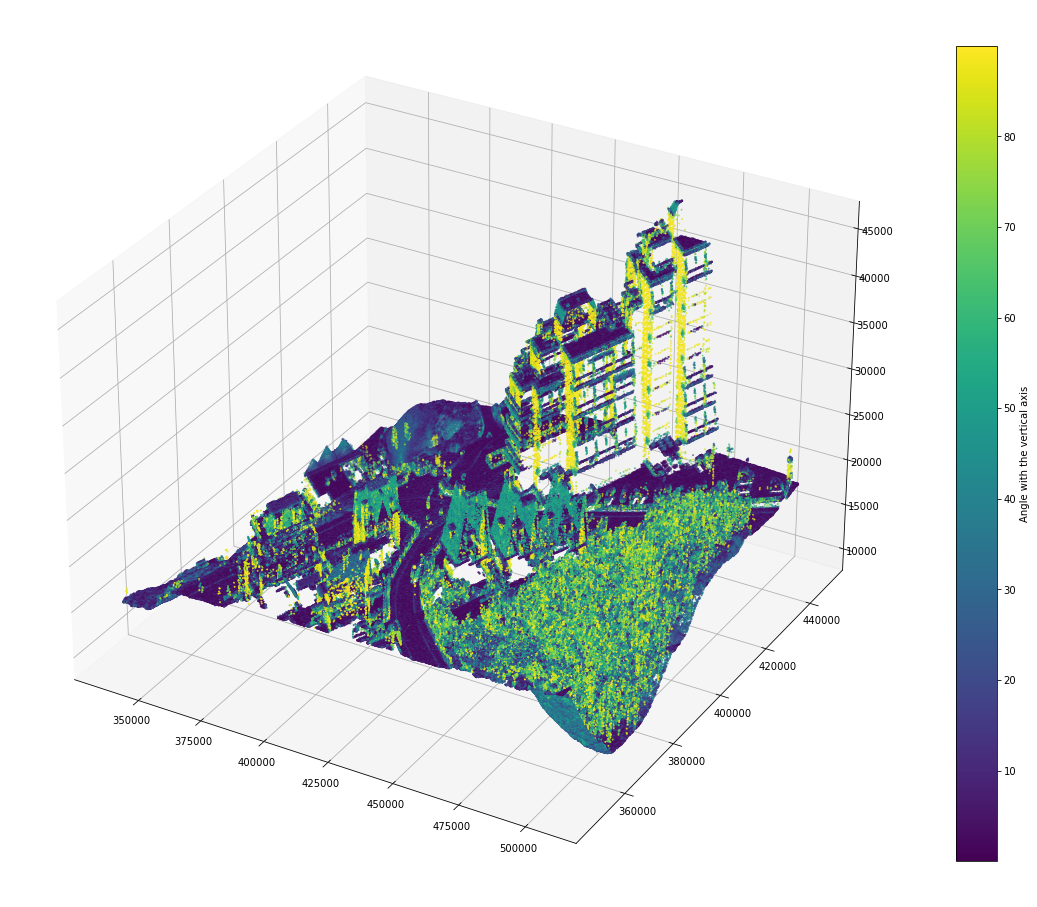

In [33]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
min_max_scaler = MinMaxScaler()
color = min_max_scaler.fit_transform(
    np.vstack([subset.red, subset.green, subset.blue]).T
)

p = ax.scatter(subset.X, subset.Y, subset.Z, s=1, c=subset.normal_angle)
ax.set_zlim3d(bottom=subset.Z.min())

plt.colorbar(p, shrink=0.75, label="Angle with the vertical axis")
plt.show()


In [34]:
## TODO delete this cell later when subset is finalized
# create a markdown table with max and min, to copy in to the cell below

for name in subset.point_format.dimension_names:
    # need to handle different methods for views that return arrays and views that return subviews
    try:
        mean_ = subset[name].mean()
    except:
        mean_ = "N/A"

    print(f"|{name}|{subset[name].max()}|{subset[name].min()}|{mean_}|  |")



|X|506423|336425|429292.5475783807|  |
|Y|447831|347833|394849.7615190117|  |
|Z|45237|8403|19564.184924570316|  |
|intensity|3402|64|942.8189832865345|  |
|return_number|5|1|N/A|  |
|number_of_returns|5|1|N/A|  |
|synthetic|0|0|N/A|  |
|key_point|0|0|N/A|  |
|withheld|0|0|N/A|  |
|overlap|0|0|N/A|  |
|scanner_channel|0|0|N/A|  |
|scan_direction_flag|1|0|N/A|  |
|edge_of_flight_line|1|0|N/A|  |
|classification|0|0|0.0|  |
|user_data|7|6|6.481019619766423|  |
|scan_angle|-3000|-4667|-3794.8262143866364|  |
|point_source_id|103|102|102.55177239640155|  |
|gps_time|270040552.1816593|270039062.8002339|270039884.3703773|  |
|red|65280|11776|34933.534884552784|  |
|green|65280|12544|34257.16123262926|  |
|blue|65280|9984|31645.35646450736|  |
|nir|0|0|0.0|  |
|Deviation|65535.0|0.0|603.9157977572299|  |
|Reflectance|19.290000915527344|-14.789999961853027|-5.444933312188677|  |
|Amplitude|34.02000045776367|0.6399999856948853|9.42818983316471|  |
|normal_angle|89.99967179015843|0.0157254648448

a) Investigate the data set: describe each of its columns and assess the spread in values in each column. What is the meaning of each attribute?

| Column name         | max                | min                    | average               | description |
| ------------------- | ------------------ | ---------------------- | --------------------- | ----------- |
| X                   | 506423             | 336425                 | 429292.5475783807     |             |
| Y                   | 447831             | 347833                 | 394849.7615190117     |             |
| Z                   | 45237              | 8403                   | 19564.184924570316    |             |
| intensity           | 3402               | 64                     | 942.8189832865345     |             |
| return_number       | 5                  | 1                      | 1.1828812172482248    |             |
| number_of_returns   | 5                  | 1                      | 1.3674346752991253    |             |
| synthetic           | 0                  | 0                      | 0.0                   |             |
| key_point           | 0                  | 0                      | 0.0                   |             |
| withheld            | 0                  | 0                      | 0.0                   |             |
| overlap             | 0                  | 0                      | 0.0                   |             |
| scanner_channel     | 0                  | 0                      | 0.0                   |             |
| scan_direction_flag | 1                  | 0                      | 0.4810196197664228    |             |
| edge_of_flight_line | 1                  | 0                      | 0.0002962191261423998 |             |
| classification      | 0                  | 0                      | 0.0                   |             |
| user_data           | 7                  | 6                      | 6.481019619766423     |             |
| scan_angle          | -3000              | -4667                  | -3794.8262143866364   |             |
| point_source_id     | 103                | 102                    | 102.55177239640155    |             |
| gps_time            | 270040552.1816593  | 270039062.8002339      | 270039884.3703773     |             |
| red                 | 65280              | 11776                  | 34933.534884552784    |             |
| green               | 65280              | 12544                  | 34257.16123262926     |             |
| blue                | 65280              | 9984                   | 31645.35646450736     |             |
| nir                 | 0                  | 0                      | 0.0                   |             |
| Deviation           | 65535.0            | 0.0                    | 603.9157977572299     |             |
| Reflectance         | 19.290000915527344 | -14.789999961853027    | -5.444933312188677    |             |
| Amplitude           | 34.02000045776367  | 0.6399999856948853     | 9.42818983316471      |             |
| normal_angle        | 89.99967179015843  | 0.015725464844876056   | 21.851322488186963    |             |
| linearity15         | 0.926218614188531  | 0.00019597302723526418 | 0.2134752744229102    |             |
| planarity15         | 0.9706762822613131 | 0.001229676703891111   | 0.5955540106253252    |             |
| scat15              | 0.9484001216640616 | 0.00985768059600219    | 0.19097071495176482   |             |
| curve15             | 0.3247035997146174 | 0.0060505239029392255  | 0.09341443281745175   |             |

## Spread in RBG values

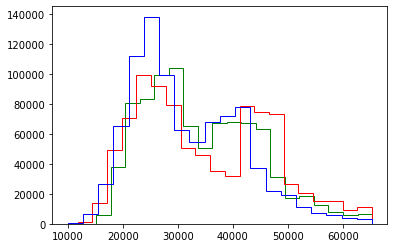

In [35]:
plt.hist(subset.green, bins=20, color="green", histtype="step")
plt.hist(subset.red, bins=20, color="red", histtype="step")
plt.hist(subset.blue, bins=20, color="blue", histtype="step")
plt.show()


b) What are ways to create a subset? Select a suitable subset of the data and visualize it in 3D. Start small, and if computer and software permits, try a bit larger subset


c) Identify at least four different object classes. Choose your classes such that together these cover a large majority of your points.

1. building
2. grass
3. pavement
4. tree
5. beach

d) Analyse which spatial scales and spectral properties are useful to distinguish your classes.

The following properties are typical of each of the classes

1. building
   1. taller than the surroundings 
2. grass
   1. high NDVI
   2. 
3. pavement
   1. 
4. tree
   1. taller that it is wide or long
5. beach

e) Extract training data for each of your object classes. Divide your training data in two parts, one for training, and one for validation. What could be the influence of  imbalances in your training data? How could your division in training and validation data affect your results?


f) Find a suitable implementation of the Random Forest algorithm. What are its parameters? What would be good settings for these parameters, given your classification task? Apply Random Forest on your data using only your observed features, to make sure your setup is correct.


# Questions
## Describe the properties of the data (sub)set that you will classify: 
### How many points? 

In [36]:
print(f"The selected subset contains {len(subset)} points")



The selected subset contains 894608 points


### What area does it cover? 

In [37]:
print(
    f"Bounding box used to create the subset is between {xmin} and {xmax} longitude and {ymin} and {ymax} latitude (referenced to the coordinates in the LAZ file [EPSG:28992])"
)


Bounding box used to create the subset is between 89316.42414516 and 89486.42414516 longitude and 472827.83174913 and 472927.83174913 latitude (referenced to the coordinates in the LAZ file [EPSG:28992])



### What observed features will you use? 
### Visualize your final subset, including the useful observed features. 

(894608, 3)


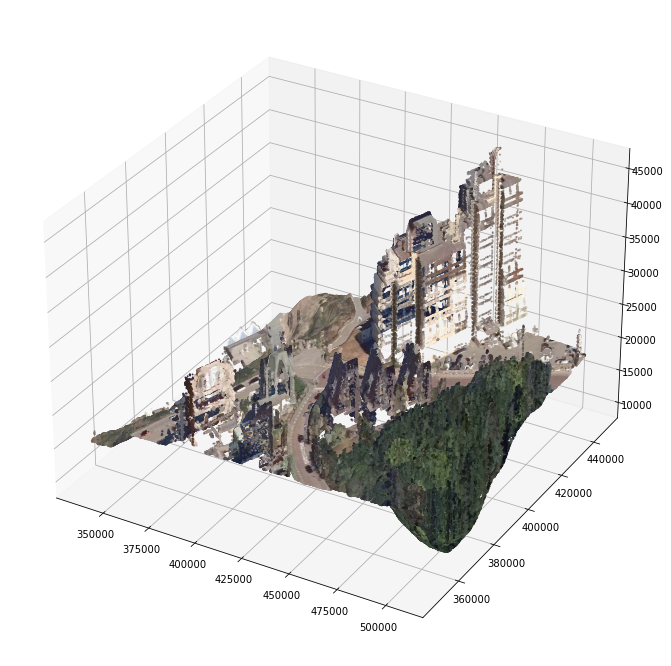

In [38]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
min_max_scaler = MinMaxScaler()
color = min_max_scaler.fit_transform(
    np.vstack([subset.red, subset.green, subset.blue]).T
)


print(color.shape)
ax.scatter(subset.X, subset.Y, subset.Z, s=1, c=color)
ax.set_zlim3d(bottom=subset.Z.min())

plt.show()



### Describe your at least four different object classes; 

For each point determine neighborhoods of k1, k2, ... points (using e.g. an efficient data structure), and use these k1, k2, ... points to estimate several feature values.



**2. Describe $\gt$ 20 different geometric attributes, obtained using at least 2 different neighborhood sizes, to characterize your points. What are the dimensions of the data covariance matrix you use to compute the geometric features? Give one example on how you determine the PCA eigenvalues of one k-neighborhood. Indicate for each feature how it could help to distinguish your classes, given also the neighborhood sizes you consider.**

The geometric attributes were computed using a covariance matrix in 3D. To describe the geometry of real world features, fitting the PCA plane in 3D makes the most sense. For every point in the subset, the nearest *k* points were found using a KDtree, which is an efficient data structure for finding the nearest features in 3D space. When working with such a large cloud, the computational expense is very important to be practical to run on a personal computer. Once the k nearest neighbors are found, a PCA model is trained on the XYZ location of the k-neighborhood, which returns 3 vectors (the eigenvectors of the Covariance matrix). The three vectors point in direction of the most variance, the 2nd most variance, and normal to the other two, respectively. The trained PCA model also returns the eigenvalues covariance matrix, which can be used to compute the following features:

3. Compute all geometric features for all points in your subset using Python. Visualize selected results, e.g. by combining features in a false color visualization and/or using histograms. Which features are best at discriminating your classes? Why?

In [39]:
def fc_vis_and_hist(point_cloud_subset, geometric_array, name):
    # create a 3d visualization
    fig = plt.figure(figsize=(24, 10))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    assert len(point_cloud_subset) == len(geometric_array)

    p = ax.scatter(subset.X, subset.Y, subset.Z, s=1, c=geometric_array)
    plt.colorbar(p, shrink=0.75, label=name)
    ax.set_zlim3d(bottom=subset.Z.min())
    # plt.title(name)

    # plt.show()

    # create a histogram
    # plt.figure(figsize=(12,7))
    ax = fig.add_subplot(1, 2, 2)

    ax.hist(geometric_array, bins=20)
    plt.suptitle(name)
    plt.xlabel(f"values of {name}")
    plt.ylabel("Count of points")
    plt.show()

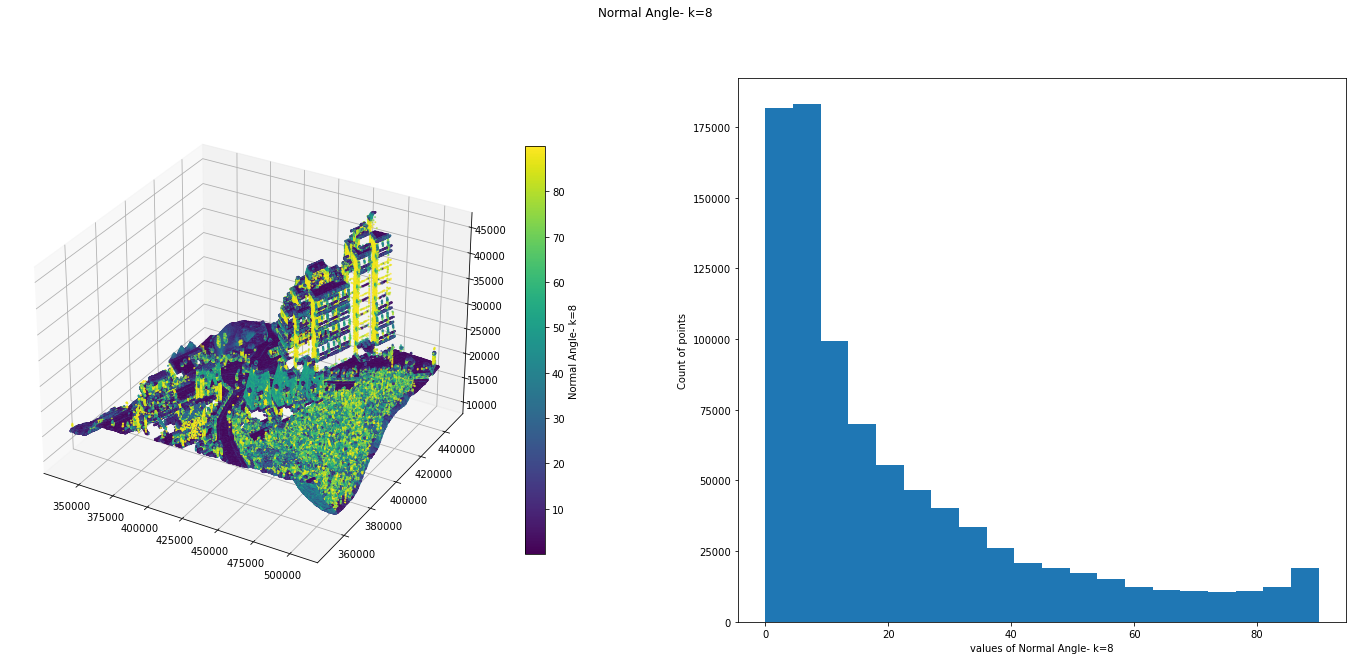

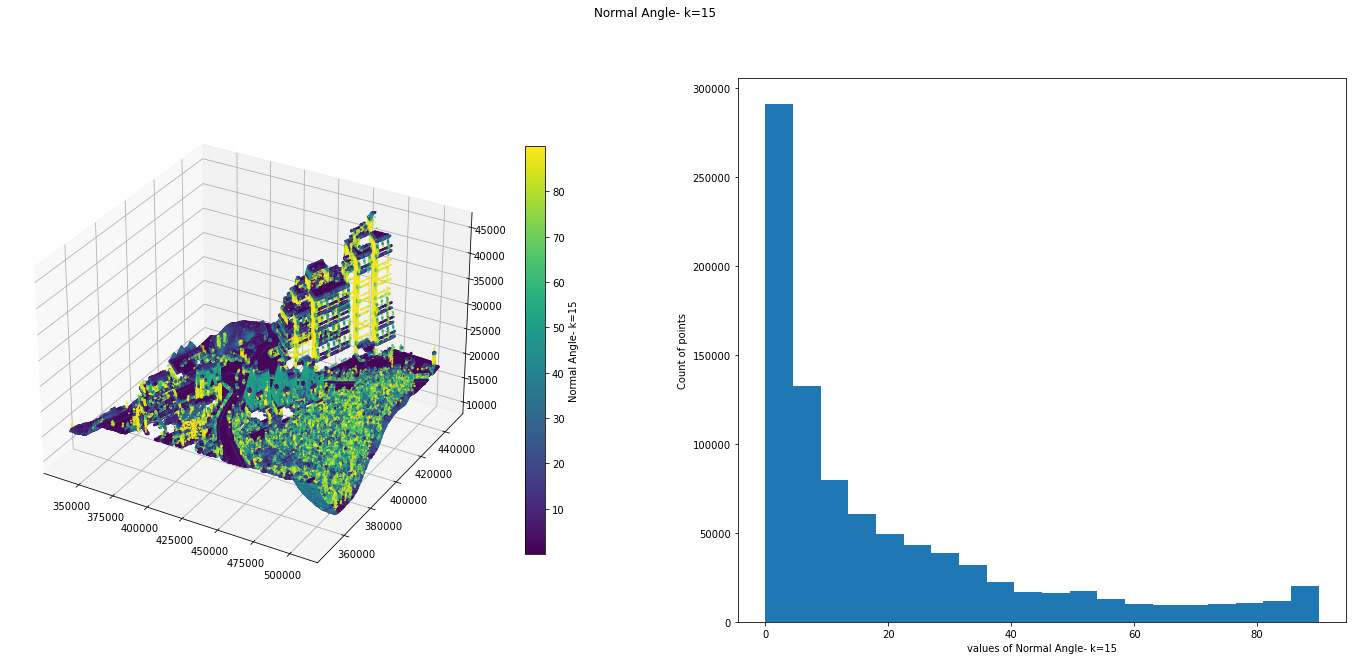

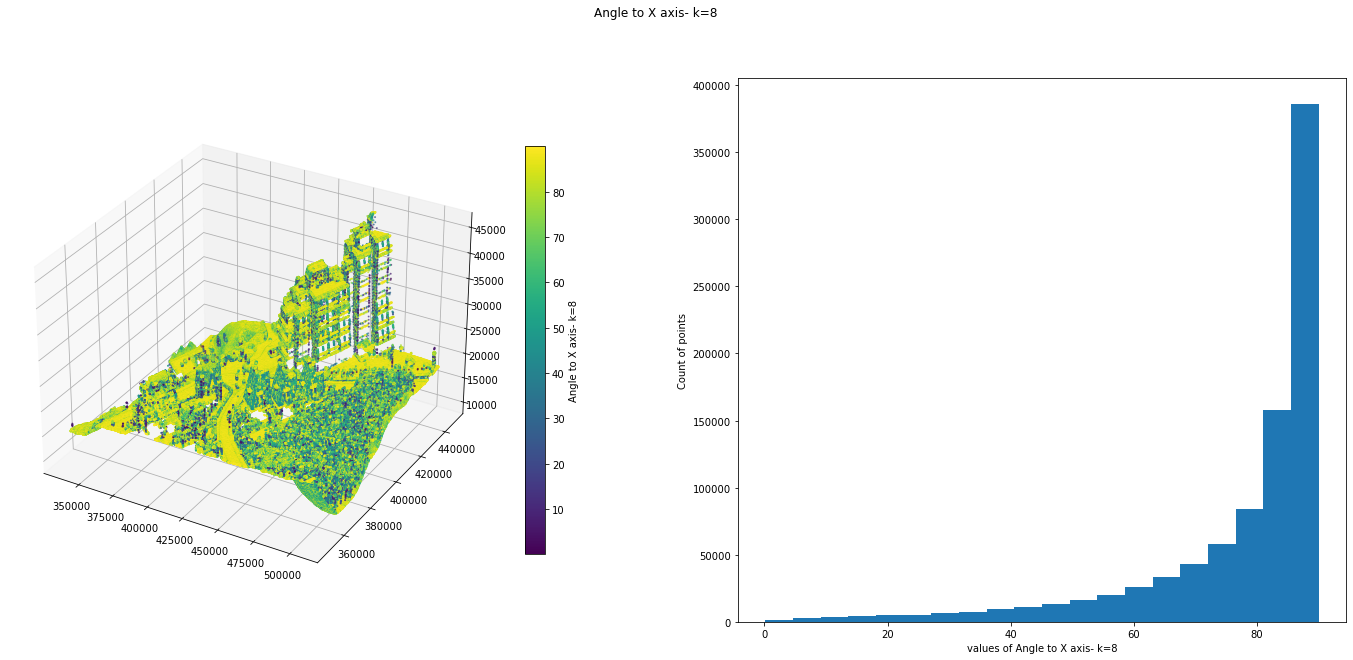

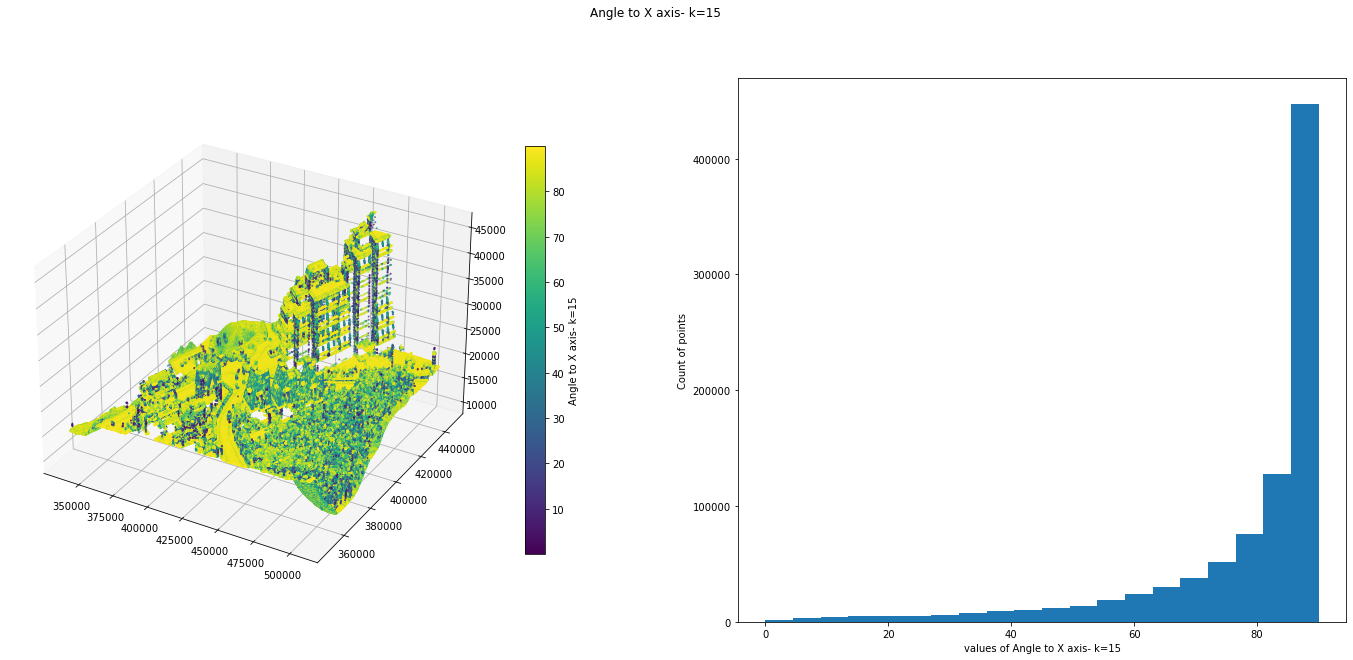

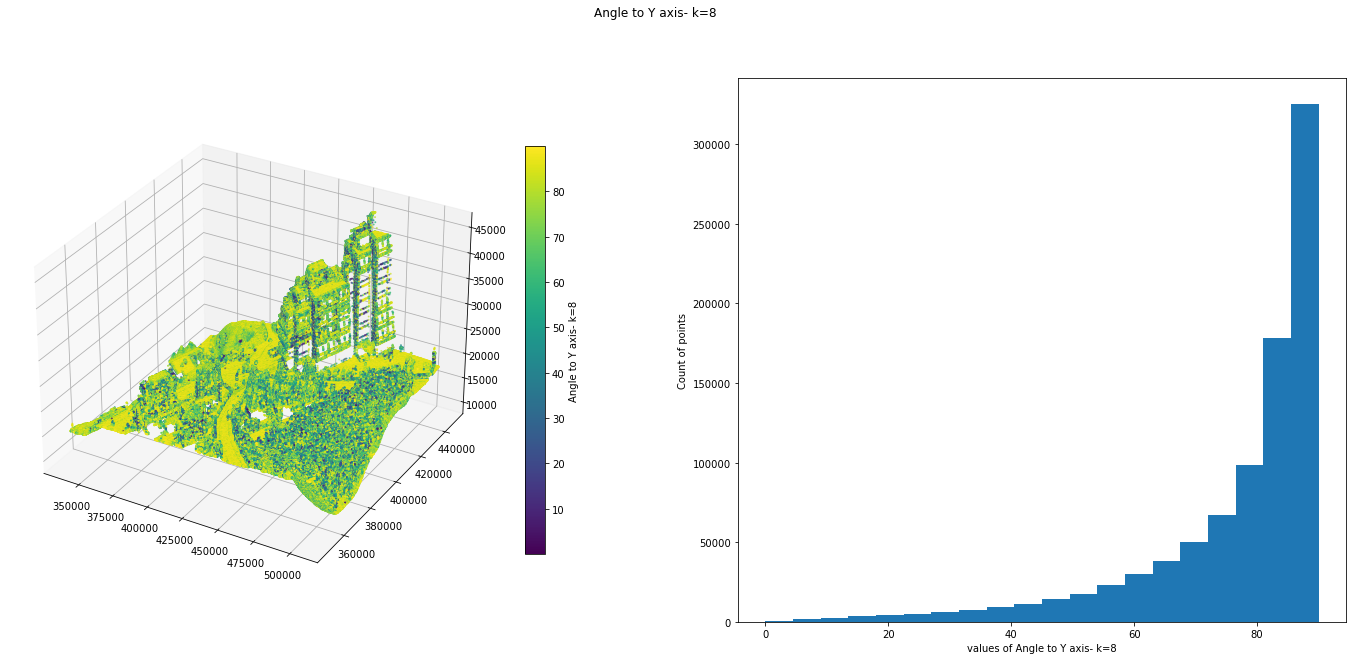

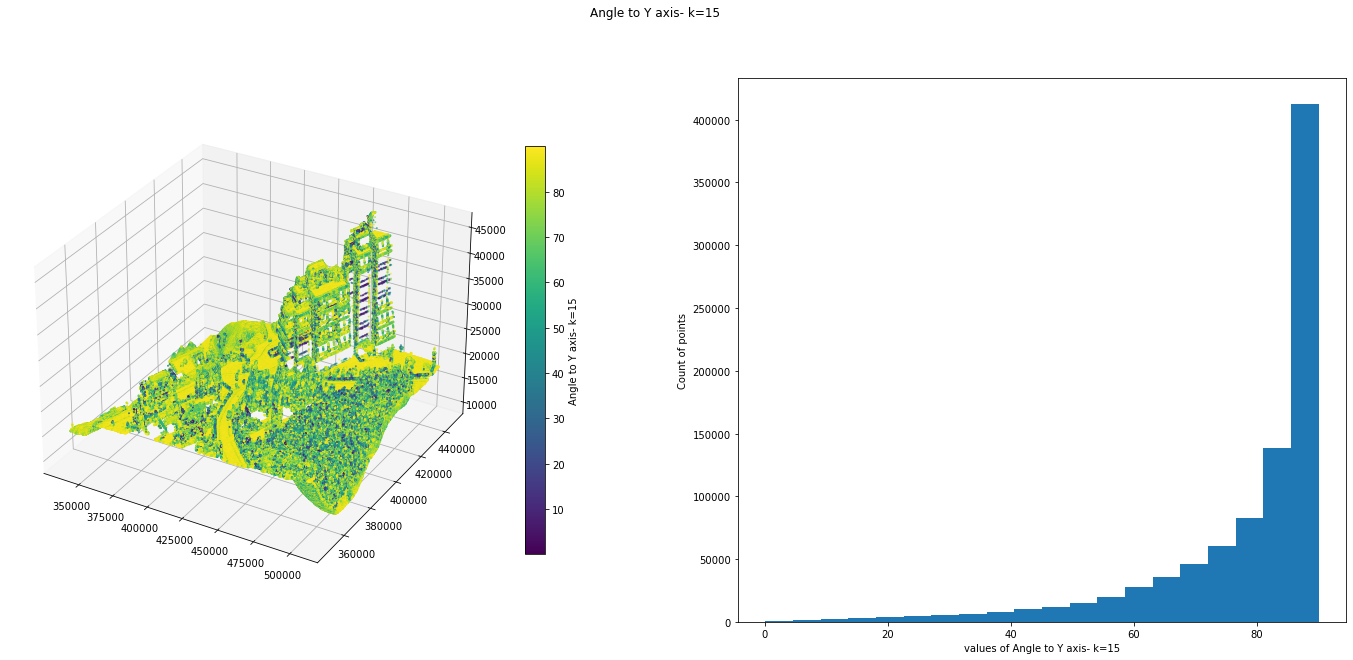

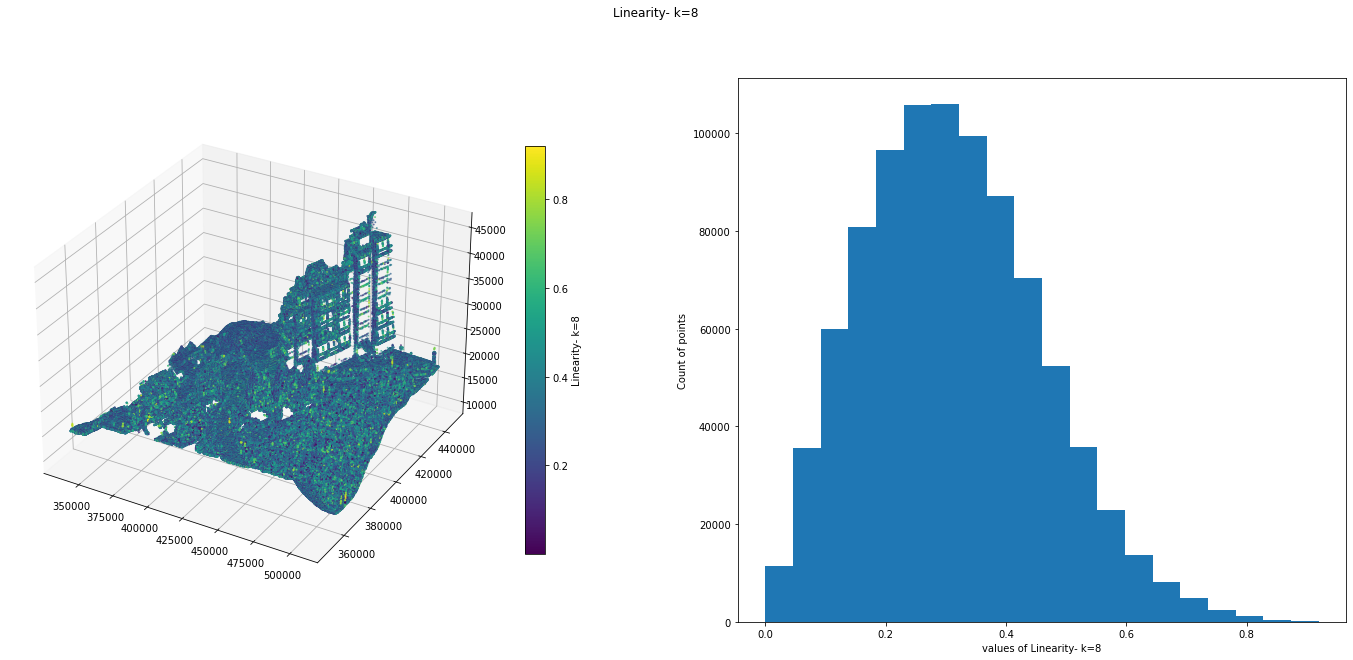

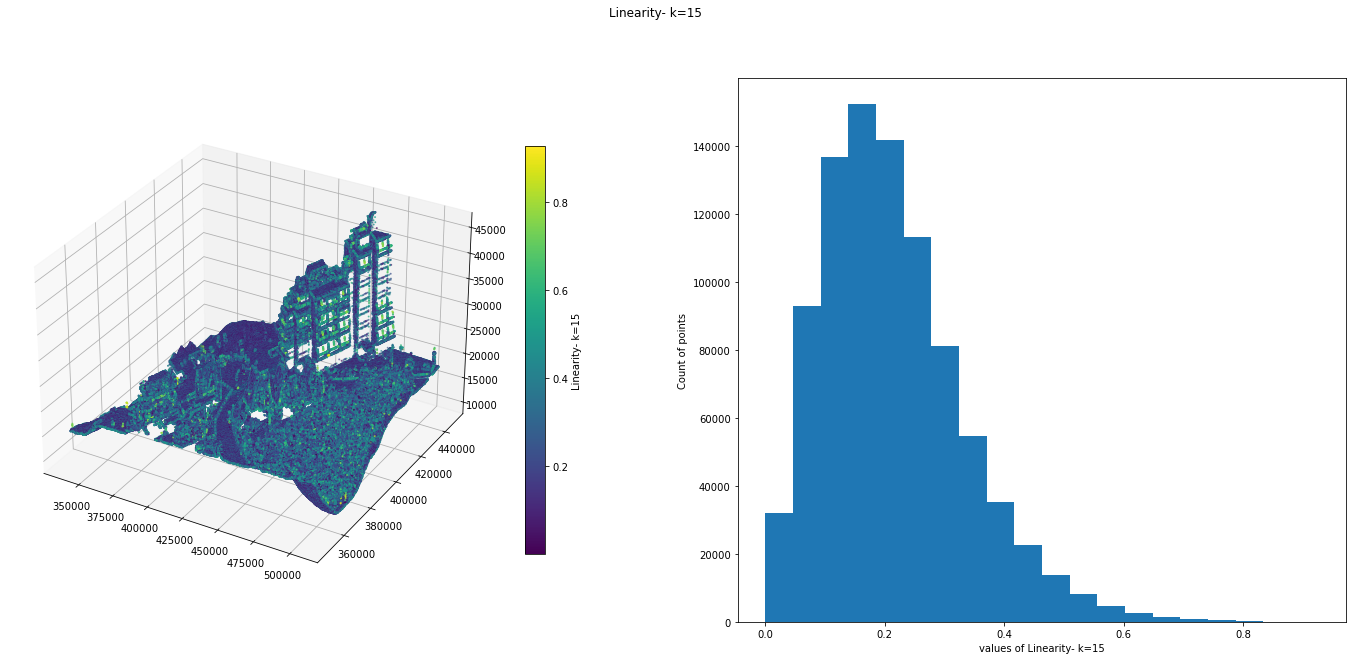

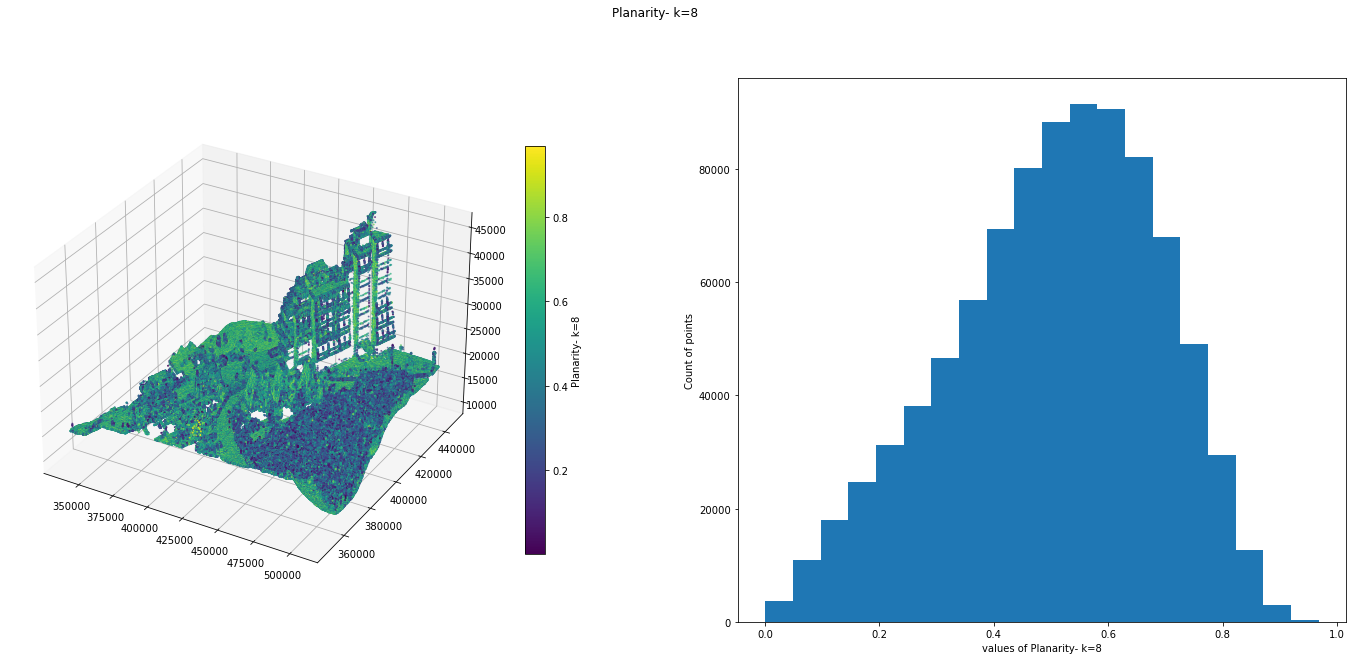

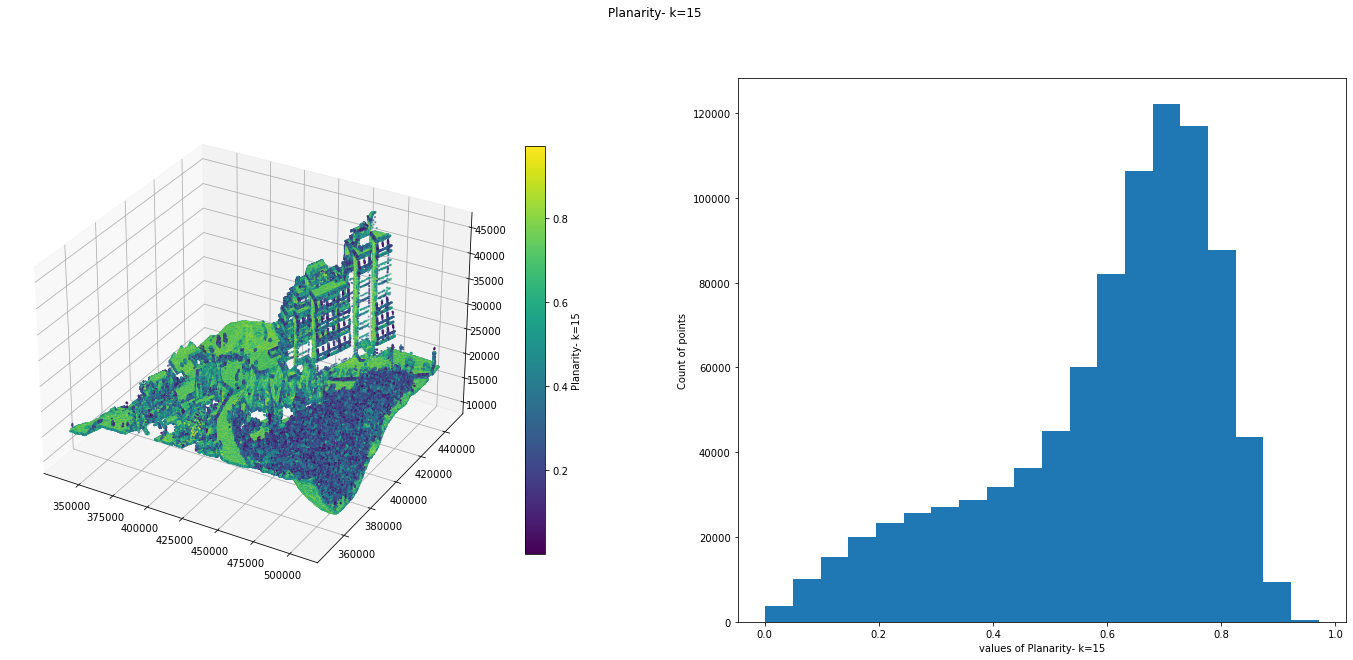

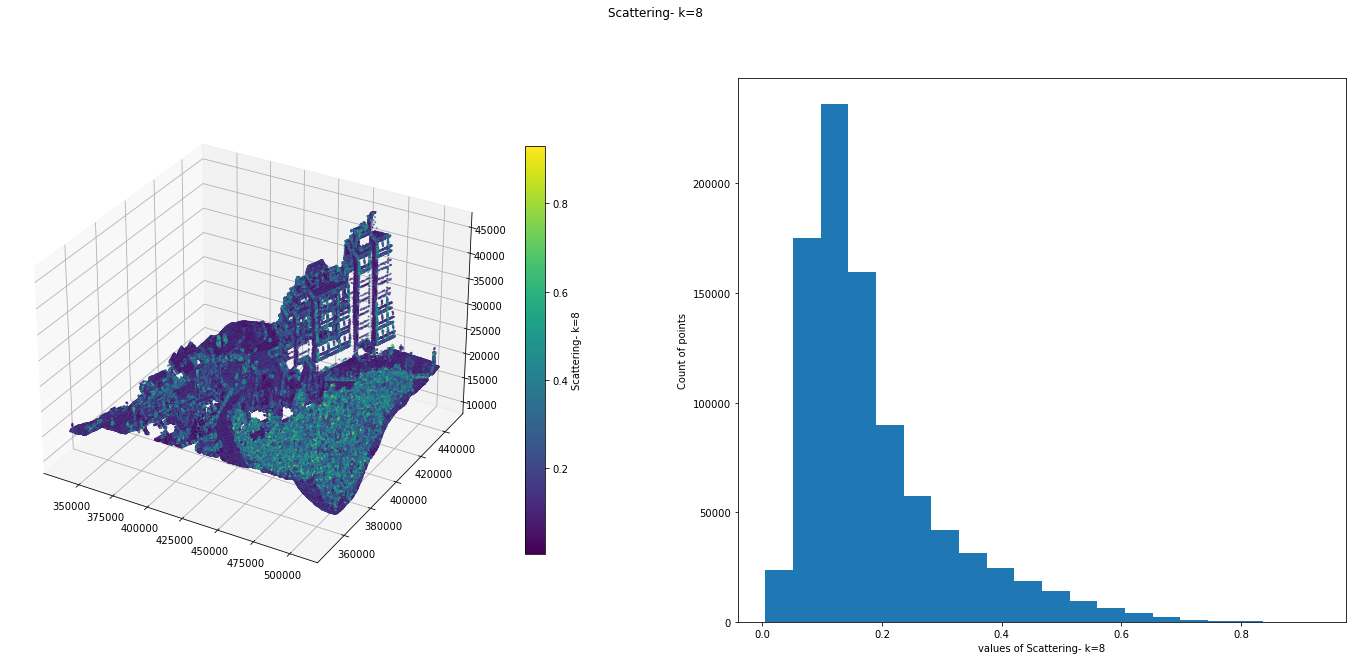

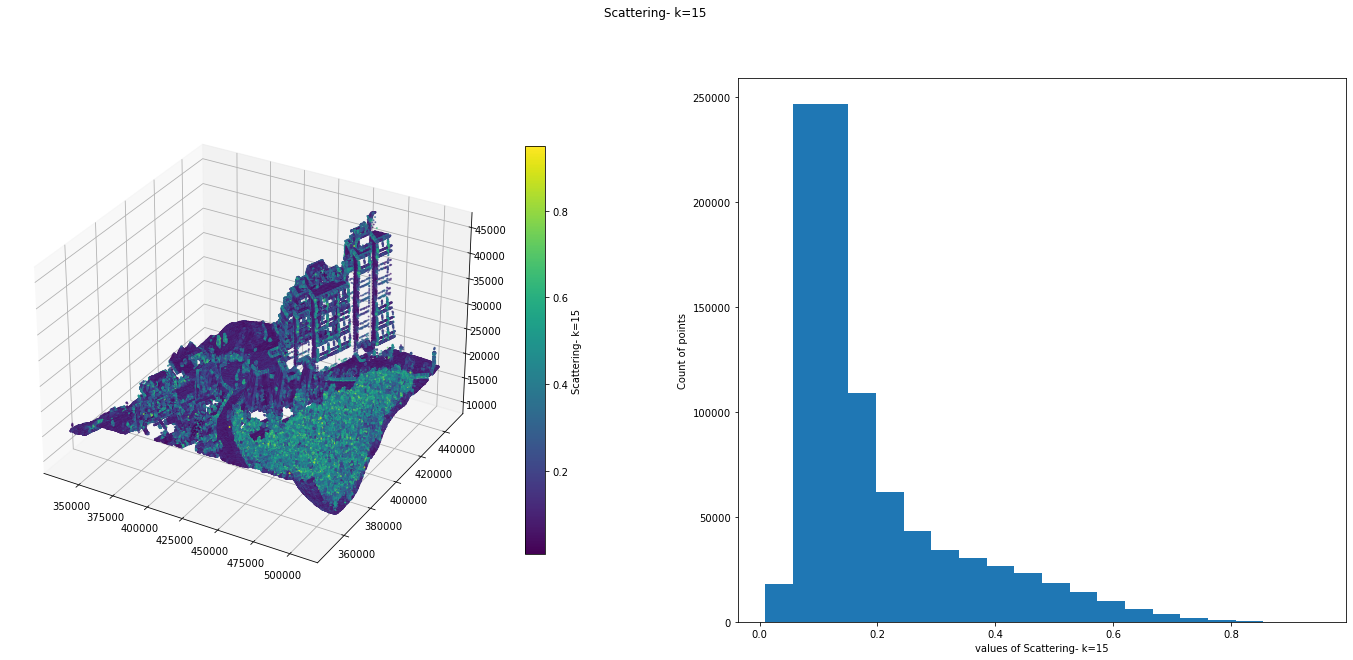

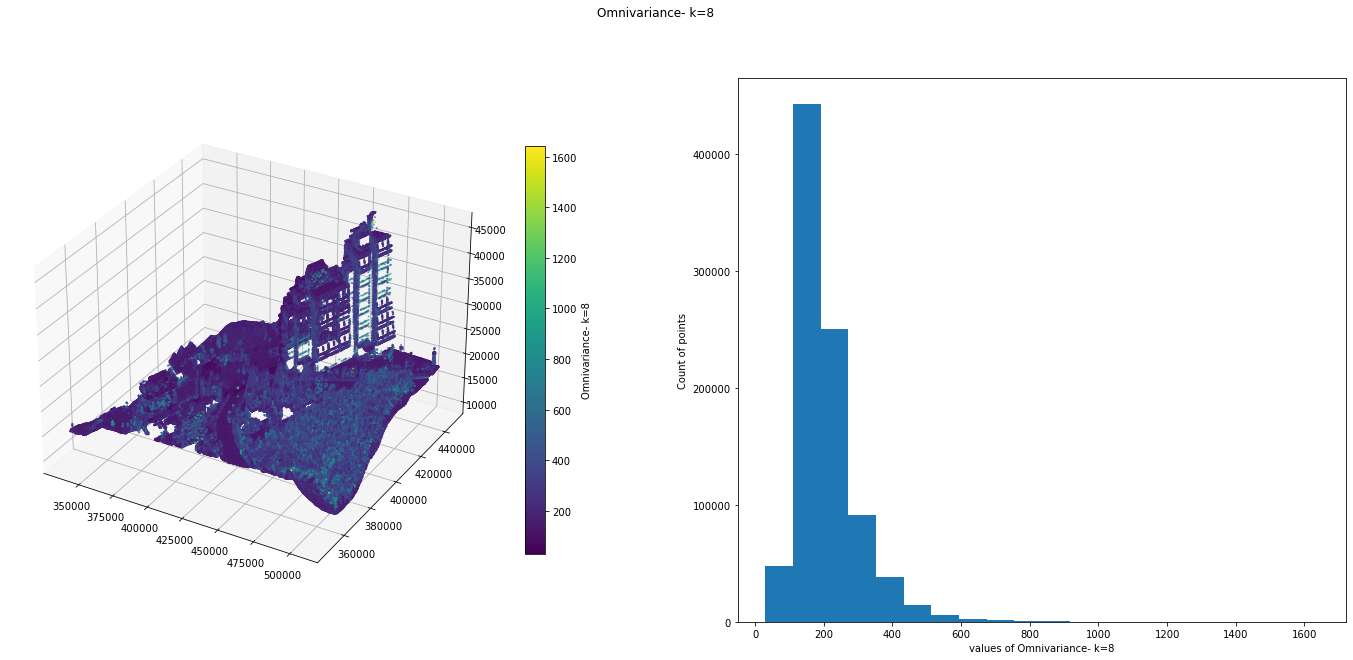

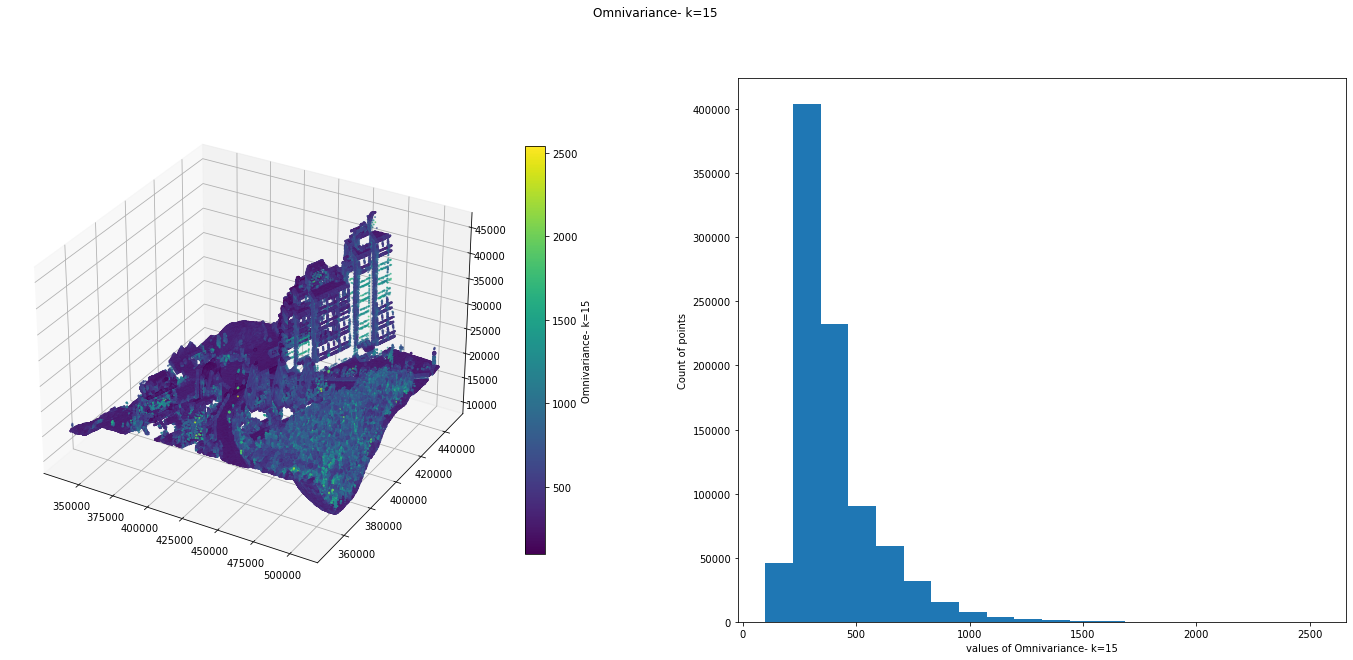

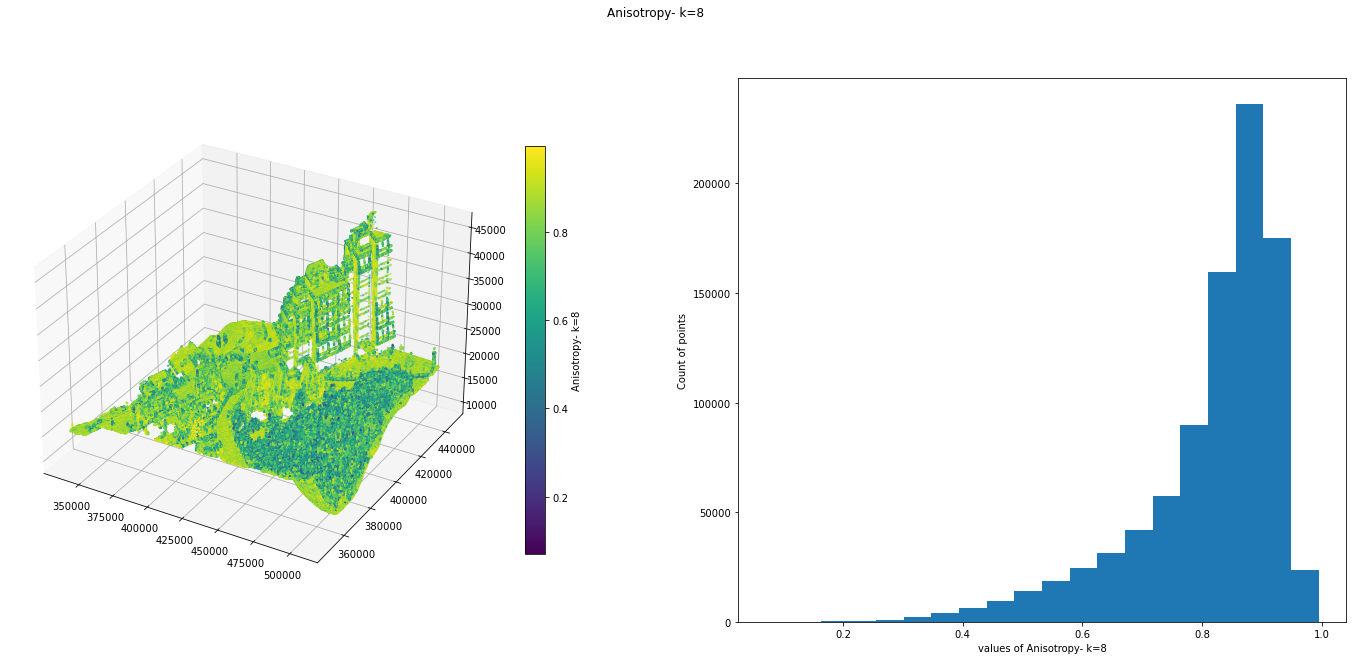

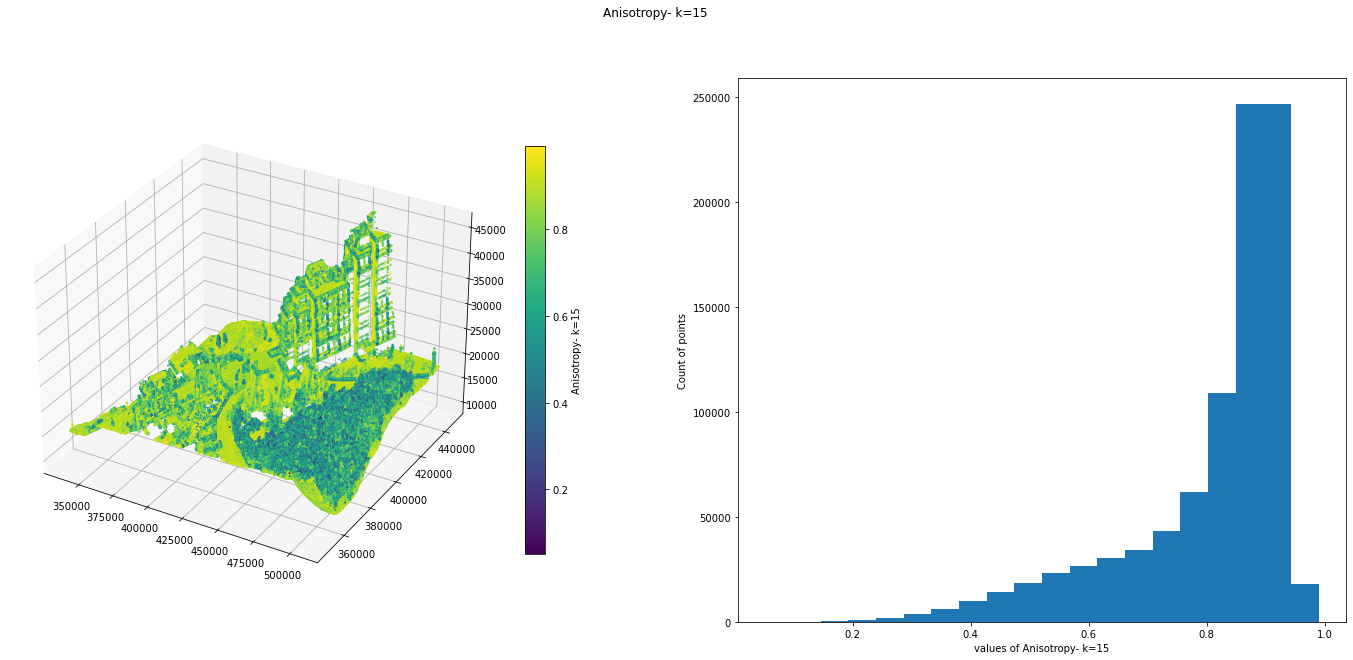

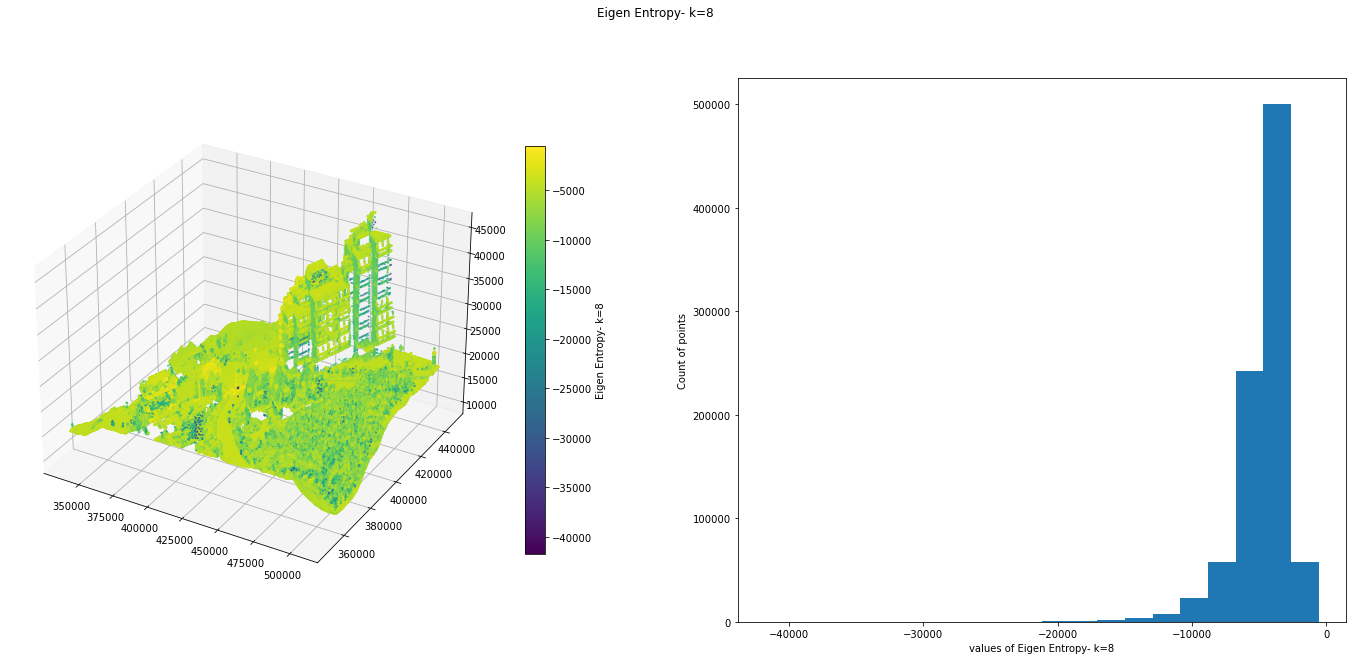

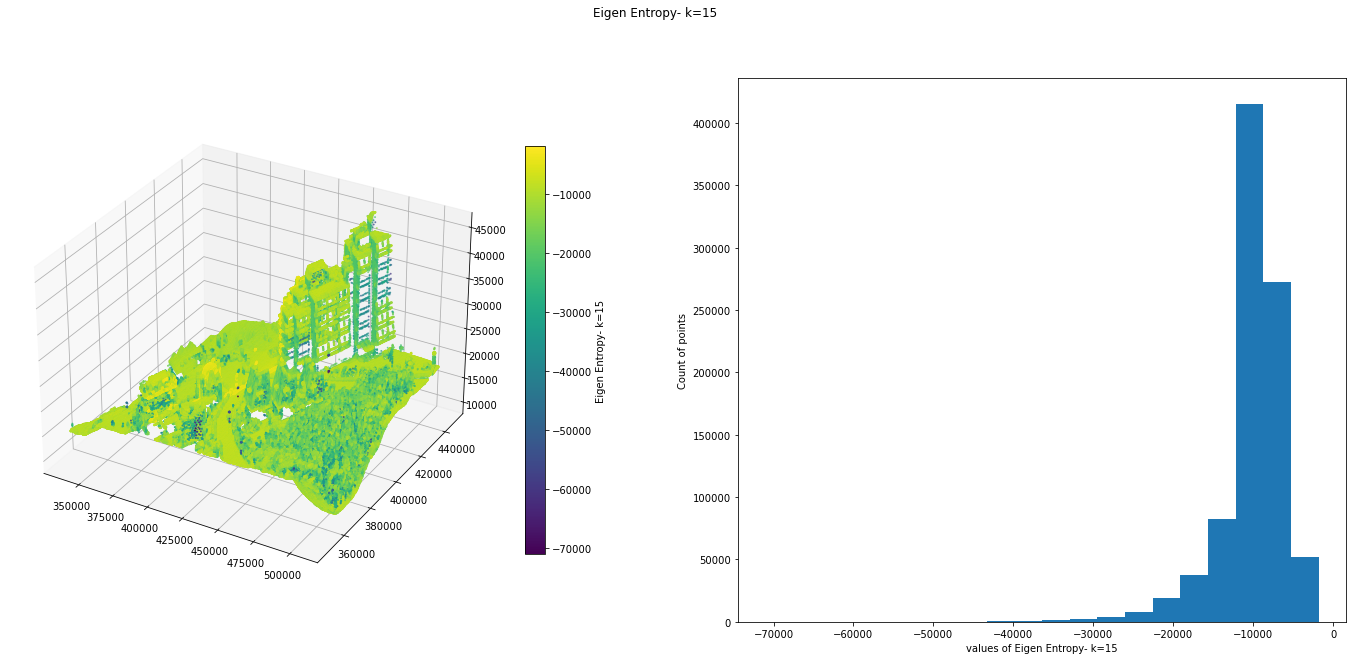

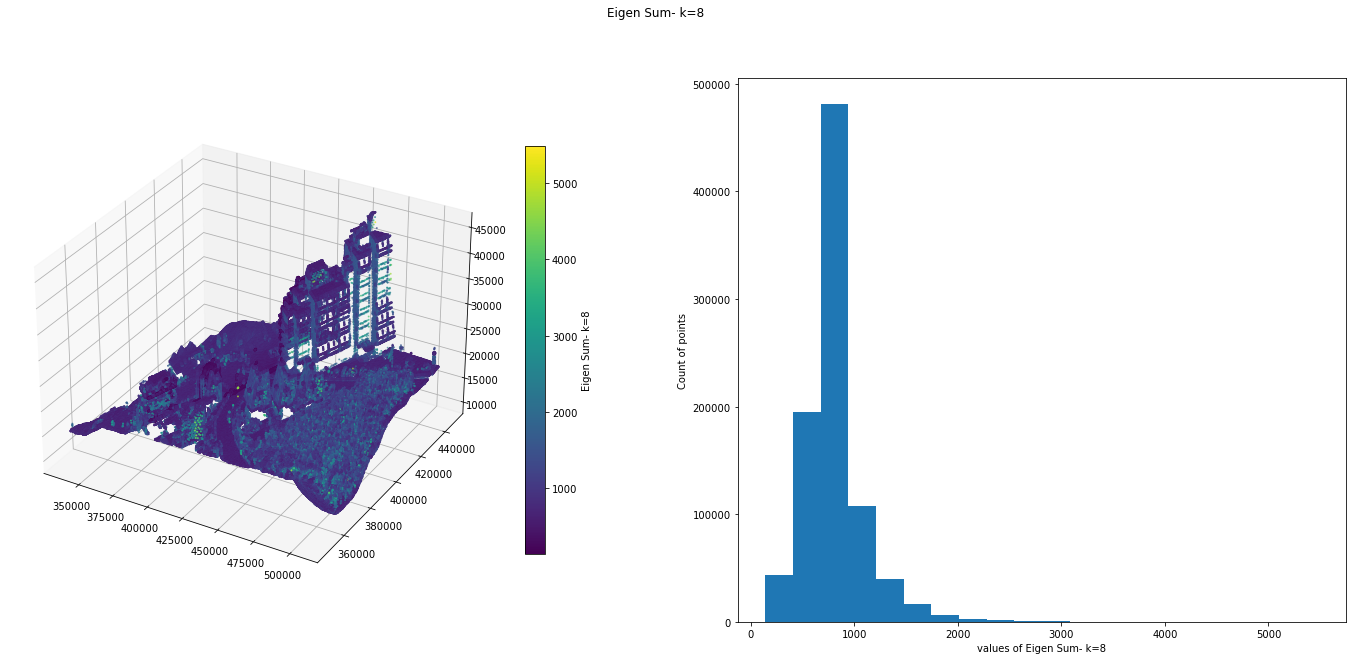

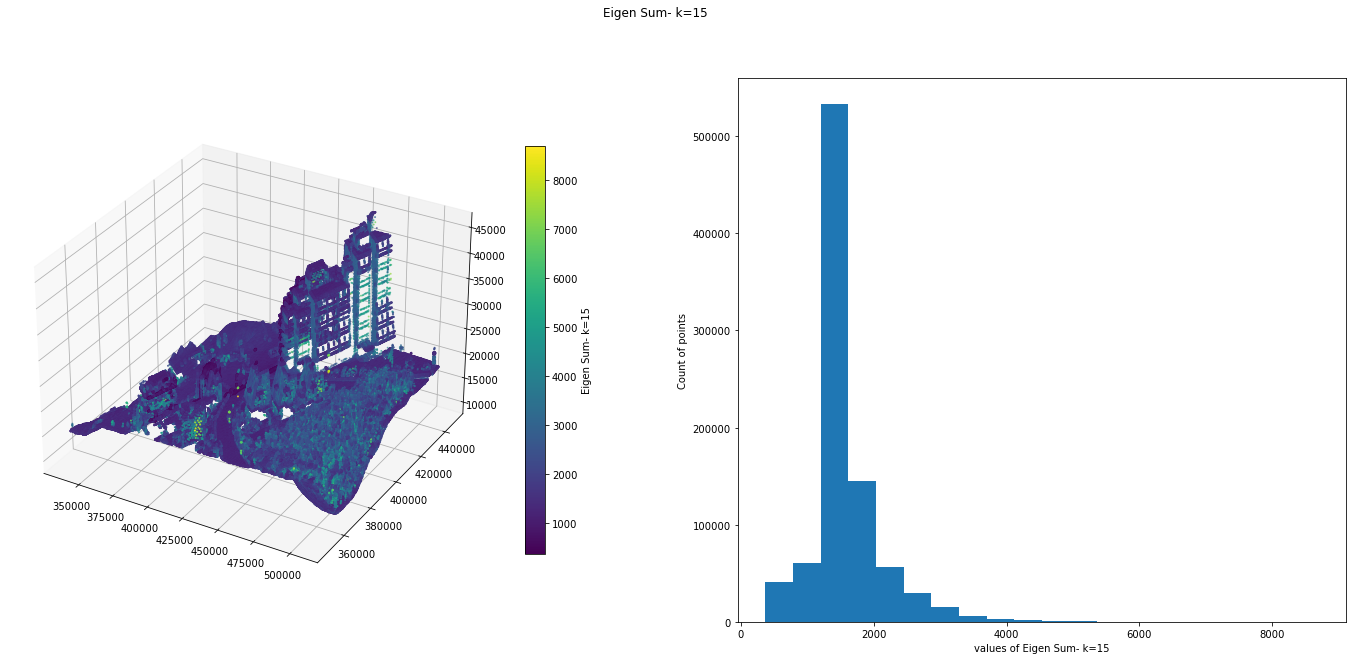

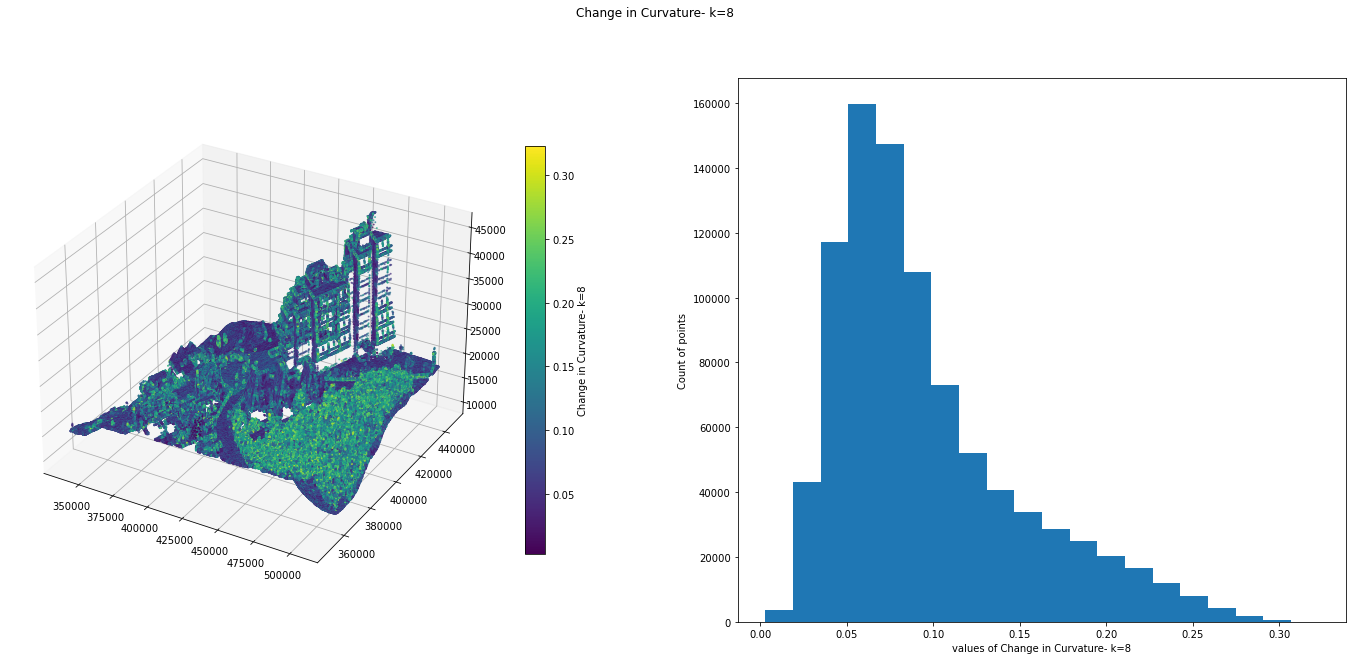

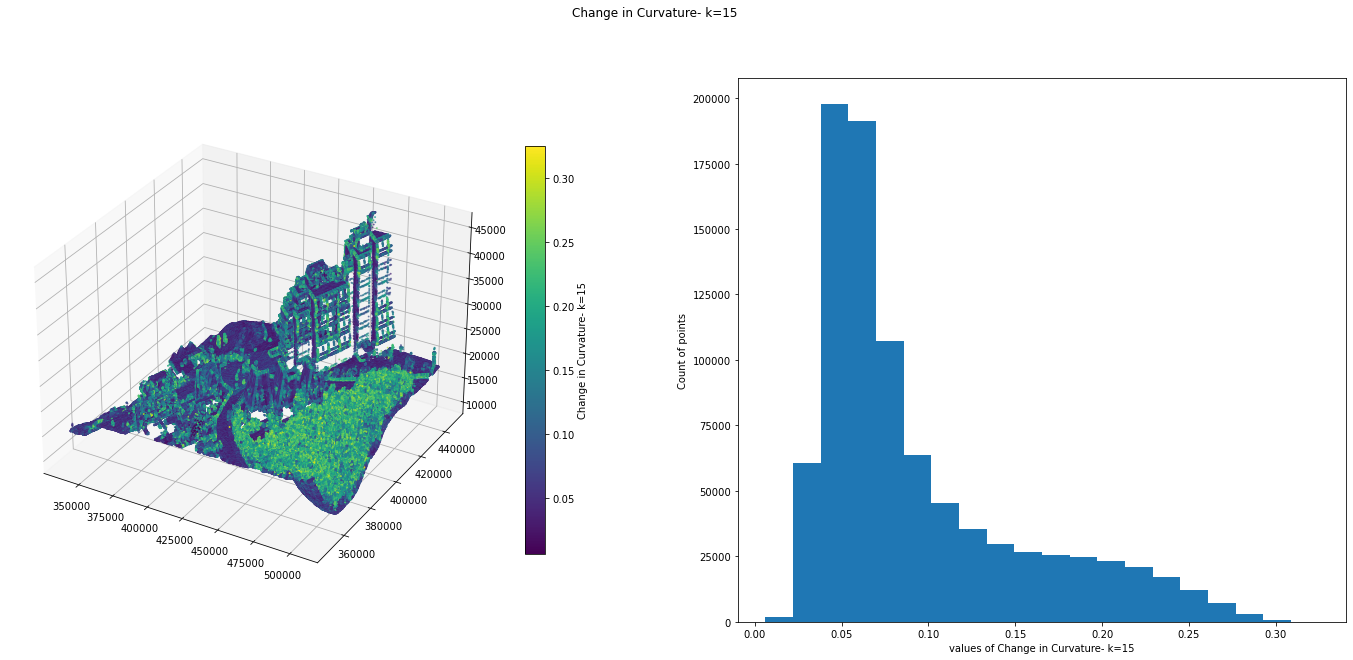

In [40]:
geometric_feat_names = [
    "Normal Angle",
    "Angle to X axis",
    "Angle to Y axis",
    "Linearity",
    "Planarity",
    "Scattering",
    "Omnivariance",
    "Anisotropy",
    "Eigen Entropy",
    "Eigen Sum",
    "Change in Curvature",
]


for column8, column15, name in zip(
    pca_results8.T, pca_results15.T, geometric_feat_names
):
    fc_vis_and_hist(subset, column8, name + "- k=8")
    fc_vis_and_hist(subset, column15, name + "- k=15")

4. Describe and visualize your training data. Is your training data balanced? Make sure that a zone of your point cloud data is really ’unseen’, that is that no training data is taken from that zone, so you can inspect if Random Forest also works there.

The training data is a set of 495,213 points that was created by manually creating polygons representing some desired classes, and the finding which points lie within those polygons when projected onto the 2d plane. The final count of training points for each category is:

| Class     | Number of points |
| --------- | ---------------- |
| Trees     | 190,242          |
| Grass     | 105,998          |
| Buildings | 910,39           |
| Sand      | 14,489           |
| Road      | 93,455           |

The selected training data is shown in the figure below:

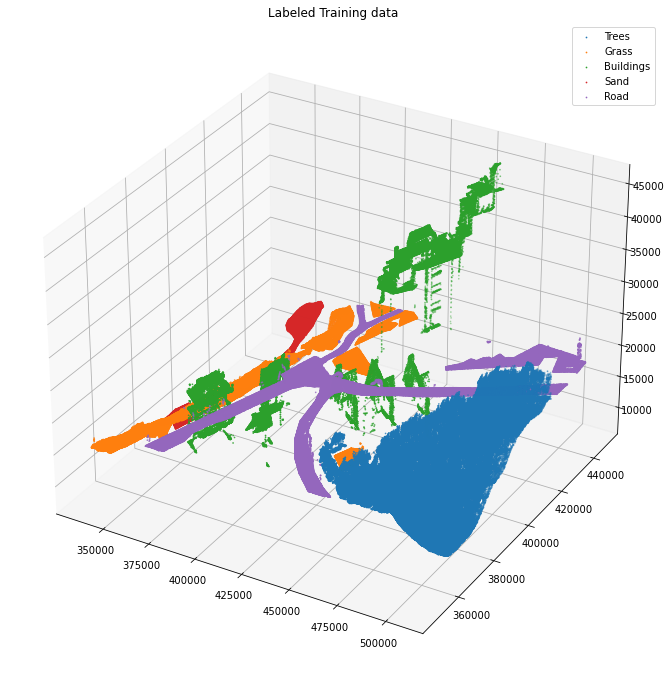

In [64]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

for i,name in enumerate(['Trees','Grass','Buildings','Sand','Road']):
    set = labelled_df[labelled_df.label==i+1]
    ax.scatter(set.X,set.Y,set.Z,label=name,s=0.5)
plt.title('Labeled Training data')
plt.legend()
plt.show()


5. Feed your training data to Random Forest using at least 10 of your best geometric and observed features. What settings did you use?


6. Classify your point cloud data and visualize and discuss your result. What went well? Give also examples where the classifier mixed up classes. What are possible explanations for these confusions? How are the classification results on the unseen zone?